# Experimental Results in Section 5

## Import necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import os
import pandas as pd
from itertools import product
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
from collections import defaultdict

## Load ground truth parameters

In [2]:
# Load ground truth parameters
with open('../data/ground_truth.pkl', 'rb') as f:
    res = pkl.load(f)
    params = res['params']
print('Ground truth parameters:', params)

Ground truth parameters: [ 0.36310104  0.7465673   0.32377172 -0.21252407  0.08090729 -0.09540857
 -0.40639496 -0.15332593 -0.24158926  0.17760716 -0.04599298]


## Section 5.4: AAE with Other Approaches

### Define utility functions

In [3]:
def compute_bias_reduction(n_trials, n_real, n_max_aug, g_models, methods, metric='rbias', display=True):
    y = defaultdict(lambda: (float('inf'), float('inf'), float('inf')))
    for method, g_model in product(methods, g_models):
        res_file = f'../res/{g_model}_{method}_{n_real}_{n_max_aug}_{n_trials}.pkl'
        if not os.path.exists(res_file):
            if display:
                print('{}\t{}\t{}'.format(g_model, method, '-'))
            continue 
        with open(res_file, 'rb') as f:
            res = pkl.load(f)
        n_aug_list, n_real_list, sample_id_list, params_est_list = res['n_aug_list'],res['n_real_list'], res['sample_id_list'], np.array(res['params_list'])
        bias_list = []
        for i in range(11):
            df = pd.DataFrame({'n_real': n_real_list, 'n_aug': n_aug_list, 'sample_id': sample_id_list, 'param': params_est_list[:,i],
                            'e': np.abs(params_est_list[:,i] - params[i]), 're': (np.abs(params_est_list[:,i] - params[i]) )/ (np.abs(params[i]) + 1),  'se': (params_est_list[:,i] - params[i])**2})
            df_agg = df.groupby(['n_aug']).agg(
                bias=('e', 'mean'),
                rbias=('re', 'mean'),
                var=('param', lambda x: np.var(x, ddof=0)),
                mse=('se', 'mean')).reset_index()
            bias_list.append(np.array(df_agg[metric]) * 100)
        bias_list = np.array(bias_list)
        bias_redu = bias_list - bias_list[:,0].reshape(11,1)  # relative_bias_reduction
        if display:
            print('{}\t{}\t{:.3f}'.format(g_model, method, np.mean(bias_redu[:,-1])))
        y[method, g_model] = (np.mean(bias_redu[:,-1]), np.mean(bias_list[:,0].reshape(11,1)), np.mean(bias_list[:,-1].reshape(11,1)))

    return y

In [4]:
def pairwise_t_test(sample1, sample2):
    # Perform one-sample t-test on the difference between samples
    diff = sample2 - sample1
    t, p = stats.ttest_1samp(diff, 0)
    return p/2 if t > 0 else 1 - p/2

In [5]:
def grouped_t_test(n_trials, n_real, n_max_aug, method, metric='re', display=True):

    res_files = {
        'naive':f'../res/naive_{method}_{n_real}_{n_max_aug}_{n_trials}.pkl',
        'a':f'../res/naive_{method}_{0}_{n_max_aug}_{n_trials}.pkl',
        'ppi': f'../res/ppi_{method}_{n_real}_{n_max_aug}_{n_trials}.pkl',
        'ppi+': f'../res/ppi+_{method}_{n_real}_{n_max_aug}_{n_trials}.pkl',
        'aae': f'../res/nn_{method}_{n_real}_{n_max_aug}_{n_trials}.pkl',
    }
    re_list = {}
    re_list['p'] = np.zeros(n_trials)
    for res_file_name, res_file in res_files.items():
        if not os.path.exists(res_file):
            continue
        f = open(res_file, 'rb')
        res = pkl.load(f)
        n_aug_list, n_real_list, sample_id_list, params_est_list = res['n_aug_list'],res['n_real_list'], res['sample_id_list'], np.array(res['params_list'])
        f.close() 

        re_list[res_file_name] = np.zeros(n_trials)
        for i in range(11):
            df = pd.DataFrame({'n_real': n_real_list, 'n_aug': n_aug_list, 'sample_id': sample_id_list, 'param': params_est_list[:,i],
                            'e': np.abs(params_est_list[:,i] - params[i]), 're': (np.abs(params_est_list[:,i] - params[i]) )/ (np.abs(params[i]) + 1),  'se': (params_est_list[:,i] - params[i])**2})
            re_list[res_file_name] += np.array(df[df['n_aug'] == n_max_aug][metric])
            if res_file_name == 'aae':
                re_list['p']  += np.array(df[df['n_aug'] == 0][metric])

    # Conduct pairwise t-tests between AAE and other methods
    p_values = []
    for res_file_name in ['a', 'naive', 'p', 'ppi', 'ppi+']:
        if res_file_name in re_list and 'aae' in re_list and np.mean(re_list[res_file_name]) < 1000:
            p_value = pairwise_t_test(re_list['aae'], re_list[res_file_name])
            p_values.append(p_value)
    
    # Record maximum p-value if any tests were conducted
    if p_values:
        return max(p_values)

### Table 3: Bias Reduction from Human-data-only Estimator

In [7]:
methods = ['gpt-0613', 'cot-gpt-0613', 'gpt-0125', 'cot-gpt-0125', 'gpt-4', 'cot-gpt-4', 'gpt-4o',  'cot-gpt-4o', 'fs-gpt-4o', 'ft-gpt-4o']
g_models = ['nn', 'naive', 'ppi', 'ppi++']
df = pd.DataFrame()
for n_real in [50,100,150,200]:
    y = compute_bias_reduction(n_trials=50, n_real=n_real, n_max_aug=1000, g_models = g_models, methods = methods, display=False)
    y0 = compute_bias_reduction(n_trials=50, n_real=0, n_max_aug=1000, g_models = g_models, methods = methods, display=False)
    cols = pd.MultiIndex.from_tuples([(n_real, 'Pure AI'),(n_real, 'Naive'), (n_real, 'PPI'), (n_real, 'PPI++'), (n_real, "AAE")])
    df1 = pd.DataFrame({
        cols[0]: [y0[method, 'naive'][2] - y[method, 'naive'][1] for method in methods], \
        cols[1]: [y[method, 'naive'][0] for method in methods], \
        cols[2]: [y[method, 'ppi'][0] for method in methods], \
        cols[3]: [y[method, 'ppi++'][0] for method in methods],\
        cols[4]: [y[method, 'nn'][0] for method in methods]}, index=methods)
    df = pd.concat([df, df1], axis=1)

# Replace values > 1000 with '-'
df = df.map(lambda x: '-' if abs(x) > 1000 else x)
# Display DataFrame with 2 decimal places
df = df.map(lambda x: '{:.2f}'.format(float(x)) if x != '-' else x)
df

50                                100                      \
             Pure AI   Naive PPI PPI++     AAE Pure AI  Naive    PPI PPI++   
gpt-0613       -5.45  -10.80   -     -  -13.72    1.30  -4.53      -     -   
cot-gpt-0613   20.18   16.81   -     -  -14.79   26.93  20.62      -     -   
gpt-0125       -8.91   -9.92   -     -  -13.29   -2.16  -3.21      -     -   
cot-gpt-0125   15.67   10.95   -     -  -14.84   22.43  14.71  25.28  5.14   
gpt-4          14.81   12.39   -     -  -15.70   21.56  16.20      -     -   
cot-gpt-4      21.77   18.12   -     -  -15.80   28.53  22.49  23.29  4.13   
gpt-4o         15.70   13.05   -     -  -15.55   22.46  17.34  23.05  4.93   
cot-gpt-4o     20.61   16.50   -     -  -15.74   27.37  20.49  19.30  4.42   
fs-gpt-4o      12.46    9.71   -     -  -16.16   19.22  14.56  17.83  4.46   
ft-gpt-4o       4.83    3.18   -     -  -16.66   11.59   7.96  22.90  4.90   

                        150                                200                \
                AAE Pure AI  Naive    PPI PPI++    AAE Pure AI  Naive    PPI   
gpt-0613      -6.90    6.90  -2.06      -     -  -2.09    7.56  -1.79      -   
cot-gpt-0613  -8.09   32.53  23.06  19.34  2.93  -3.12   33.19  21.10  16.08   
gpt-0125      -6.50    3.43   0.86  24.15  3.48  -1.78    4.10   1.60  16.70   
cot-gpt-0125  -7.72   28.02  17.72  16.44  3.39  -2.74   28.69  16.16  10.94   
gpt-4         -8.04   27.16  20.03  11.61  2.91  -3.12   27.82  19.20  10.90   
cot-gpt-4     -8.30   34.12  26.33  13.86  2.95  -3.37   34.79  24.10  10.21   
gpt-4o        -8.06   28.05  20.90  13.93  3.23  -3.07   28.72  19.65  11.13   
cot-gpt-4o    -8.06   32.96  23.65  13.28  3.29  -3.31   33.63  21.28  10.20   
fs-gpt-4o     -8.26   24.81  18.41  11.68  2.78  -3.44   25.48  17.50  11.31   
ft-gpt-4o     -9.58   17.18  12.46  13.25  2.87  -4.81   17.85  11.31  11.21   

                           
             PPI++    AAE  
gpt-0613         -  -0.96  
cot-gpt-0613  2.19  -1.82  
gpt-0125      1.92  -0.76  
cot-gpt-0125  1.95  -1.81  
gpt-4         1.94  -2.04  
cot-gpt-4     1.96  -2.27  
gpt-4o        1.92  -1.84  
cot-gpt-4o    1.99  -2.25  
fs-gpt-4o     2.18  -2.10  
ft-gpt-4o     1.93  -3.36

### Perform One-sample t-Tests for each pair of comparison

In [30]:
# Create DataFrame to store p-values
methods = ['gpt-0613', 'cot-gpt-0613', 'gpt-0125', 'cot-gpt-0125', 'gpt-4', 'cot-gpt-4', 'gpt-4o', 'cot-gpt-4o', 'fs-gpt-4o', 'ft-gpt-4o']
n_reals = [50, 100, 150, 200]
p_values_df = pd.DataFrame(index=methods, columns=n_reals)

# Fill DataFrame with p-values
for method in methods:
    for n_real in n_reals:
        p_value = grouped_t_test(n_trials=50, n_real=n_real, n_max_aug=1000, method=method, metric='re', display=False)
        p_values_df.loc[method, n_real] = p_value        

p_values_df_cutoff = p_values_df.map(lambda x: '{:.0e}'.format(x) if x < 0.001 else '{:.3f}'.format(x))
p_values_df_cutoff

,50,100,150,200
gpt-0613,8e-11,4e-08,0.470,0.979
cot-gpt-0613,1e-15,3e-12,2e-05,4e-04
gpt-0125,2e-14,2e-09,0.006,0.091
cot-gpt-0125,2e-15,4e-11,2e-04,7e-04
gpt-4,6e-17,3e-12,3e-05,2e-04
cot-gpt-4,2e-16,2e-09,9e-06,3e-05
gpt-4o,1e-16,2e-12,4e-05,2e-04
cot-gpt-4o,2e-16,3e-12,8e-06,5e-05
fs-gpt-4o,9e-18,2e-12,6e-06,9e-05
ft-gpt-4o,2e-18,2e-14,8e-10,5e-09


### Figure 3: Illustration of Feature Parameters

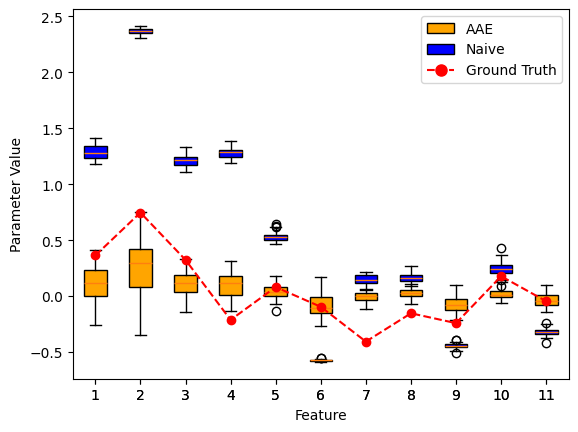

In [31]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
fig, ax = plt.subplots()
ax.set_ylabel('Parameter Value')
ax.set_xlabel('Feature')
colors=['orange', 'blue']

g_models=['nn', 'naive']
for j, g_model in enumerate(g_models):
    estimated_params = []
    res_file = f'../res/{g_model}_cot-gpt-4_50_1000_50.pkl'
    with open(res_file, 'rb') as f:
        res = pkl.load(f)

    n_aug_list, n_real_list, sample_id_list, params_est_list = res['n_aug_list'], res['n_real_list'], res['sample_id_list'], np.array(res['params_list'])
    for i in range(11):
        df = pd.DataFrame({'n_real': n_real_list, 'n_aug': n_aug_list, 'sample_id': sample_id_list, 'param': params_est_list[:,i]})
        df = df[df['n_aug'] == 1000]
        estimated_params.append(df['param'])

    bplot = ax.boxplot(estimated_params, patch_artist=True, zorder=j)  # fill with color
    for patch in bplot['boxes']:
        patch.set_facecolor(colors[j])

legend_elements = [Patch(facecolor='orange', edgecolor='black', label='AAE'), 
                    Patch(facecolor='blue', edgecolor='black', label='Naive'), 
                    Line2D([0], [0], marker='o', linestyle='--', color='r', label='Ground Truth', markerfacecolor='r', markersize=8)]

ax.plot(range(1,12), params, '--o', label='Ground Truth', color='r',zorder=3)
ax.legend(handles=legend_elements)
plt.show()


## Section 5.5: Economic Value of AAE

### Define utility functions

In [32]:
def find_n_equiv(total_bias, b):
    for i in range(len(total_bias)-1):
        if b <= total_bias[i] and b > total_bias[i+1]:
            break
    return ((b - total_bias[i])/(total_bias[i + 1] - total_bias[i]) + i) * 25 + 25

In [33]:
def one_sided_p_value(x, mu):
    t, p = stats.ttest_1samp(x, mu)
    return p/2 if t > 0 else 1 - p/2

### Table 4: Percentage of Saving in Data Size

In [34]:
# Load estimation results with real data with small increments
res_file = '../res/naive_real_25_250_50.pkl'
with open(res_file, 'rb') as f:
    res = pkl.load(f)
n_aug_list, n_real_list, sample_id_list, params_est_list = res['n_aug_list'],res['n_real_list'], res['sample_id_list'], np.array(res['params_list'])

bias_list = []
for i in range(11):
    df = pd.DataFrame({'n_real': n_real_list, 'n_aug': n_aug_list, 'sample_id': sample_id_list, 'param': params_est_list[:,i],
                    're': (np.abs(params_est_list[:,i] - params[i]) )/ (np.abs(params[i]) + 1)})
    df_agg = df.groupby(['n_aug']).agg(rbias=('re', 'mean')).reset_index()
    bias_list.append(np.array(df_agg['rbias']) * 100)

bias_list = np.array(bias_list)
total_bias = []
for i in range(bias_list.shape[1]):
    total_bias.append(np.sum(bias_list[:,i]))

In [35]:
# Compute the percentage of saving in data size
n_trials = 50
n_max_aug = 1000
methods = ['gpt-0613', 'cot-gpt-0613', 'gpt-0125', 'cot-gpt-0125',  'gpt-4', 'cot-gpt-4', 'gpt-4o', 'cot-gpt-4o', 'fs-gpt-4o', 'ft-gpt-4o']
df_res = pd.DataFrame()
for n_real in [50, 100, 150, 200]:
    saving, saving_std, saving_p_value = [], [], []
    for method in methods:
        res_file = f'../res/nn_{method}_{n_real}_{n_max_aug}_{n_trials}.pkl'
        if not os.path.exists(res_file):
            continue
        with open(res_file, 'rb') as f:
            res = pkl.load(f)
        n_aug_list, n_real_list, sample_id_list, params_est_list = res['n_aug_list'],res['n_real_list'], res['sample_id_list'], np.array(res['params_list'])
        bias_list = []
        for i in range(11):
            df = pd.DataFrame({'n_real': n_real_list, 'n_aug': n_aug_list, 'sample_id': sample_id_list, 'param': params_est_list[:,i],
                            're': (np.abs(params_est_list[:,i] - params[i]))/ (np.abs(params[i]) + 1)})
            bias_list.append(np.array(df[df['n_aug'] == n_max_aug]['re']) * 100)

        bias_list = np.array(bias_list)
        bias_list = np.sum(bias_list, axis = 0)
        equiv_n_list = []
        for i in range(len(bias_list)):
            equiv_n_list.append(find_n_equiv(total_bias, bias_list[i]))
        equiv_n_list = np.array(equiv_n_list)
        saving.append(np.mean((equiv_n_list - n_real)/equiv_n_list) * 100)
        saving_std.append(np.std((equiv_n_list - n_real)/equiv_n_list * 100)/np.sqrt(n_trials))
        saving_p_value.append(one_sided_p_value((equiv_n_list - n_real)/equiv_n_list, 0))

    df1_values = [f"{s:.2f} ({std:.2f}){'*' if p > 0.05 else ''}" for s, std, p in zip(saving, saving_std, saving_p_value)]
    df1 = pd.DataFrame({'n={}'.format(n_real): df1_values}, index=methods)
    df_res = pd.concat([df_res, df1], axis=1)
    
df_res
    

,n=50,n=100,n=150,n=200
gpt-0613,73.59 (0.69),46.48 (1.64),30.97 (1.68),-0.86 (2.80)*
cot-gpt-0613,76.05 (1.63),52.84 (2.61),37.34 (2.93),8.37 (4.49)
gpt-0125,71.64 (0.77),42.67 (1.63),27.65 (1.36),-3.72 (2.75)*
cot-gpt-0125,77.24 (1.23),52.44 (1.98),36.22 (2.19),10.73 (3.77)
gpt-4,79.30 (1.20),53.23 (2.28),39.83 (2.00),14.01 (3.17)
cot-gpt-4,78.40 (1.68),53.70 (2.89),40.76 (2.22),14.96 (3.78)
gpt-4o,77.86 (1.56),51.91 (2.74),38.10 (2.41),9.39 (4.35)
cot-gpt-4o,78.81 (1.45),52.64 (2.66),41.02 (2.13),15.14 (3.82)
fs-gpt-4o,79.39 (1.41),53.79 (2.56),42.47 (1.97),13.00 (3.99)
ft-gpt-4o,79.81 (1.63),58.04 (3.22),50.20 (2.27),24.86 (4.16)
